# Corporation Sector Clustering
### Unsupervised Machine Learning with KMeans

## Introduction

This project implements both self-coded k-means and the k-means algorithm from the sklearn package to create clusters of corporations based on their financial data. Assuming that corporations within the same sector might behave similarly in terms of financial indices like current ratio, days of sales outstanding, and payables turnover, we want to determine how we can classify the number of sectors that the corporations within the data set resemble. We will create exploratory 2D data visualizations of the data using PCA dimension reduction, compare the time and memory usage of the two k-means implementations, and use elbowology to decide the correct number of sectors/clusters within the corporations in the data set. 

In [16]:
# import
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.spatial import distance 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

import matplotlib.pyplot as plt

# benchmarking
import timeit 
import time
import line_profiler 
import memory_profiler
%matplotlib inline

In [44]:
# import data
corporate_pd = pd.read_csv("../corporate_rating.csv")
print(corporate_pd.columns)
corporate_pd.head()

Index(['Rating', 'Name', 'Symbol', 'Rating Agency Name', 'Date', 'Sector',
       'currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding',
       'netProfitMargin', 'pretaxProfitMargin', 'grossProfitMargin',
       'operatingProfitMargin', 'returnOnAssets', 'returnOnCapitalEmployed',
       'returnOnEquity', 'assetTurnover', 'fixedAssetTurnover',
       'debtEquityRatio', 'debtRatio', 'effectiveTaxRate',
       'freeCashFlowOperatingCashFlowRatio', 'freeCashFlowPerShare',
       'cashPerShare', 'companyEquityMultiplier', 'ebitPerRevenue',
       'enterpriseValueMultiple', 'operatingCashFlowPerShare',
       'operatingCashFlowSalesRatio', 'payablesTurnover'],
      dtype='object')


,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790


The columns in the data set include 25 factors that measures the liquidity ratio, profitability ratio, debt ratio, operating performance ratio, and cash flow indicator ratios.

- Liquidity Measurement Ratios: currentRatio, quickRatio, cashRatio, daysOfSalesOutstanding
- Profitability Indicator Ratios: grossProfitMargin, operatingProfitMargin, pretaxProfitMargin, netProfitMargin, effectiveTaxRate, returnOnAssets, returnOnEquity, returnOnCapitalEmployed
- Debt Ratios: debtRatio, debtEquityRatio
- Operating Performance Ratios: assetTurnover
- Cash Flow Indicator Ratios: operatingCashFlowPerShare, freeCashFlowPerShare, cashPerShare, operatingCashFlowSalesRatio, freeCashFlowOperatingCashFlowRatio

These factors together predict the solvency, credit risk, and operating liquidity of the company. These factors together corresponds to the company's ability to repay its debt owners and its credit rating in general.  

To perform PCA dimension reduction in order to visualize the data in 2D, we keep the numerical variables within the dataset.

In [3]:
corporate_np = corporate_pd.drop(['Rating','Name','Symbol','Rating Agency Name','Date','Sector'],axis = 1).to_numpy()
sectors = corporate_pd[['Sector']].to_numpy()
corporate_np.shape

(2029, 25)

In [4]:
# zero-center the data adapted from lab 5 code
def standardize(data):
    data_std = data.copy()
    
    mean_vec = np.mean(data, axis=0)
    sd_vec = np.std(data, axis=0)
    
    for i in range(data.shape[1]):
        data_std[:,i] = (data[:,i] - mean_vec[i]*np.ones(data.shape[0]))/sd_vec[i]

    return data_std


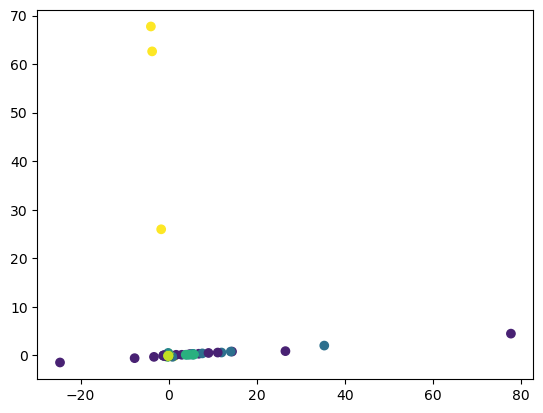

In [5]:
# standardize the data
corporate_std = standardize(corporate_np)

# visualize the data in 2D
pca = PCA(n_components=2)
corporate2D = pca.fit_transform(corporate_std)

sectorlist = list(corporate_pd.Sector.unique())
sector_num = sectors.copy()
for i in range(len(sectors)):
    sector_num[i] = sectorlist.index(sectors[i])

plt.scatter(corporate2D[:,0], corporate2D[:,1], c=sector_num)

The visualization of the original data is not so ideal given that there are extreme outliers within the data. Although most of the data are within 10 standard deviations from the mean, there are still some outliers that make it hard to see the number of clusters. Therefore we want to create an updated visualization without the outliers and more focused on the center cluster. Here we choose to keep data points that have -0.2 < x < 0.2  and y < 1.

In [6]:
# keep data points with x < 0.5
include = corporate2D[:,0]<0.5
corporate2Dnew = corporate2D[include]
sector_num1 = sector_num[include]

# keep data points with x > -0.5
include1 = corporate2Dnew[:,0]>-0.5
corporate2Dnew1 = corporate2Dnew[include1]
sector_num2 = sector_num1[include1]

# keep data points with y < 1
include2 = corporate2Dnew1[:,1]<1
corporate2Dnew2 = corporate2Dnew1[include2]
sector_num3 = sector_num2[include2]

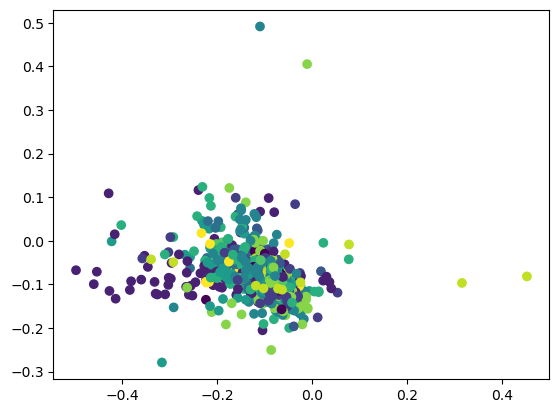

In [7]:
plt.scatter(corporate2Dnew2[:,0], corporate2Dnew2[:,1], c=sector_num3)

After zooming in towards the center, it seems that there are about 1-2 clusters within the data. However, the usual convention is to split the economy into [4 sectors](https://www.investopedia.com/ask/answers/05/industrysector.asp). 

- Primary Sector: This sector deals with the extraction and harvesting of natural resources such as agriculture and mining.
- Secondary Sector: This sector comprises construction, manufacturing, and processing. Basically, this sector comprises industries that relate to the production of finished goods from raw materials.
- Tertiary Sector: Retailers, entertainment, and financial companies make up this sector. These companies provide services to consumers.
- Quaternary Sector: The final sector deals with knowledge or intellectual pursuits including research and development (R&D), business, consulting services, and education.

We will implement k-means from scratch and explore the number of clusters.

## Self-implementation of k-means

In [8]:
def my_kmeans(array, cluster_num, rs):
    '''
    input: numpy array, cluster number k, random state
    return: the centers of the k clusters
    '''
    df = pd.DataFrame(array)
    
    # randomly assign initial centers
    centers = df.sample(cluster_num, random_state = rs).to_numpy()
    # set the number of max iterations
    max_it = 500
    
    for it in range(max_it):
        
        # label the datapoints to the nearest center
        dist = distance.cdist(array, centers)
        label = np.argmin(dist, axis = 1)
        
        # initialize the new centers
        new_center = np.ones((cluster_num, array.shape[1]))
        
        # for each cluster, calculate the average date point as the new center
        for i in range(cluster_num):
            cluster = array[label == i]
            new_center[i] = np.mean(cluster, axis = 0)
        
        # break if there is no change to the centers
        if (new_center == centers).all():
            break
        # update the centers
        else:
            centers = new_center

    return centers, label

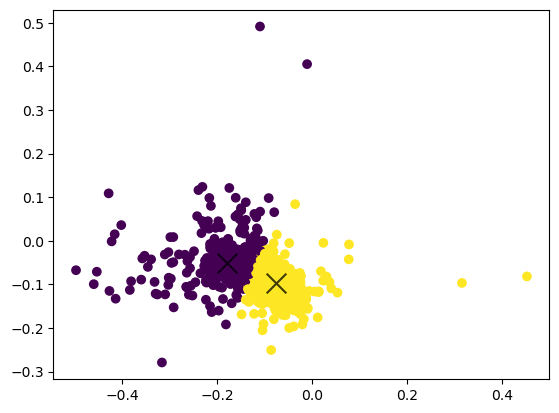

In [9]:
# visualize the datapoints with two clusters
centers2 = my_kmeans(corporate2Dnew2, 2, 1)[0]
label2 = my_kmeans(corporate2Dnew2, 2, 1)[1]

plt.scatter(corporate2Dnew2[:,0], corporate2Dnew2[:,1], c=label2)
plt.scatter(centers2[:, 0], centers2[:, 1], c='black', marker="x", s=200, alpha=0.75)

The self-implemented k-means separated the blob of data points into two clusters. Although there seems to be an even separation in terms of the number of data points, there does not seem to be a clear boundary between the two clusters.

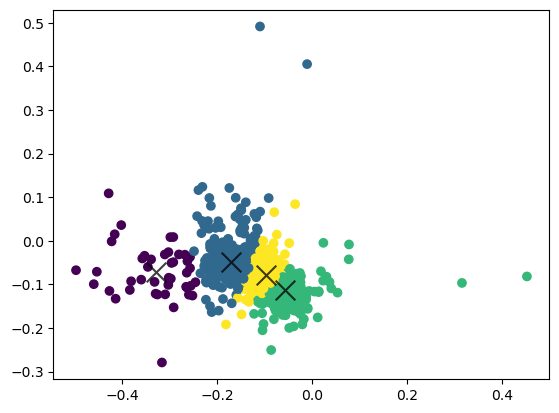

In [10]:
# visualize the datapoints with four clusters
centers4 = my_kmeans(corporate2Dnew2, 4, 1)[0]
label4 = my_kmeans(corporate2Dnew2, 4, 1)[1]

plt.scatter(corporate2Dnew2[:,0], corporate2Dnew2[:,1], c=label4)
plt.scatter(centers4[:, 0], centers4[:, 1], c='black', marker="x", s=200, alpha=0.75)

## Implementing k-means with sklearn

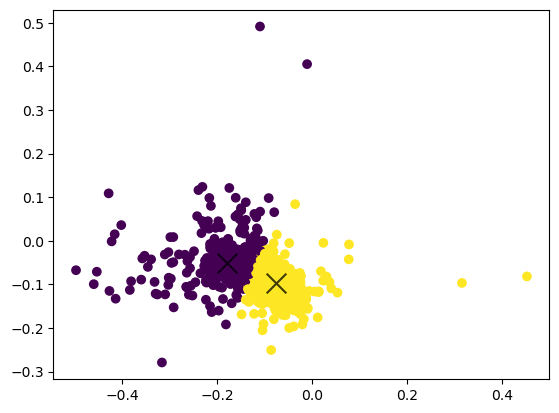

In [11]:
# k = 2

# set up the k-means algorithm
km_alg = KMeans(n_clusters=2, init="random",random_state = 1, max_iter = 200)

# fit the data
fit1 = km_alg.fit(corporate2Dnew2)
sklabels2 = fit1.labels_
skcenters2 = fit1.cluster_centers_

# plot the data
plt.scatter(corporate2Dnew2[:,0], corporate2Dnew2[:,1], c=sklabels2)
plt.scatter(skcenters2[:, 0], skcenters2[:, 1], c='black', marker="x", s=200, alpha=0.75)

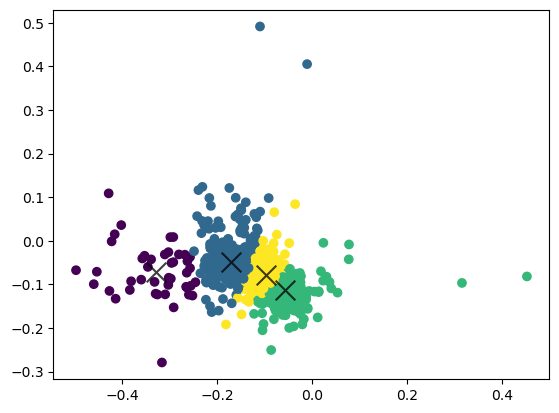

In [12]:
# k = 4

# set up the k-means algorithm
km_alg2 = KMeans(n_clusters=4, init="random",random_state = 1, max_iter = 200)

# fit the data
fit2 = km_alg2.fit(corporate2Dnew2)
sklabels4 = fit2.labels_
skcenters4 = fit2.cluster_centers_

# plot the data
plt.scatter(corporate2Dnew2[:,0], corporate2Dnew2[:,1], c=sklabels4)
plt.scatter(skcenters4[:, 0], skcenters4[:, 1], c='black', marker="x", s=200, alpha=0.75)

The sklearn implementation of k-means gives us the same color of clusters as the self-implemented k-means. Comparing the two graphs, I prefer the one with four clusters since it separates the data points to the left as a separate clsuter. Still, the boundaries between the clusters are not obvious.

## Self-implementation v.s. sklearn

We will next compare our self-implementation with the sklearn implementation of k-means. We will compare the time and memory usage of both the 2-cluster and 4-cluster models.

### Time usage

In [19]:
%%timeit
centers, labels = my_kmeans(corporate2Dnew2, 2, 1)

3.84 ms ± 344 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%%timeit
km_alg = KMeans(n_clusters=2, init="random",random_state = 1, max_iter = 200)
fit = km_alg.fit(corporate2Dnew2)
sklabels = fit.labels_
skcenters = fit.cluster_centers_

332 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In terms of time usage, self-implemented kmeans seems to run faster than the sklearn implementation of kmeans. On average, the sklearn implementation takes about 10 times the amount of time that our implementation code takes. This could also be due to the fact that algorithm initialization and fitting the label are separated into two steps and it also takes extra steps to get the fitted centers and labels for the dataset.

In [25]:
%%timeit
centers, labels = my_kmeans(corporate2Dnew2, 4, 1)

5.09 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%%timeit
km_alg = KMeans(n_clusters=4, init="random",random_state = 1, max_iter = 200)
fit = km_alg.fit(corporate2Dnew2)
sklabels = fit.labels_
skcenters = fit.cluster_centers_

348 ms ± 4.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


If we increase the number of cluster to 4, sklearn k-means still takes around 330-340 ms but self-implemented k-means took about 1.4 times the time it took for 2 clsuters. We can continue to increase the number of clusters to see if this trend continues.

In [27]:
%%timeit
centers, labels = my_kmeans(corporate2Dnew2, 8, 1)

14.3 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
%%timeit
km_alg = KMeans(n_clusters=8, init="random",random_state = 1, max_iter = 200)
fit = km_alg.fit(corporate2Dnew2)
sklabels = fit.labels_
skcenters = fit.cluster_centers_

372 ms ± 5.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
centers, labels = my_kmeans(corporate2Dnew2, 20, 1)

55.6 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%%timeit
km_alg = KMeans(n_clusters=20, init="random",random_state = 1, max_iter = 200)
fit = km_alg.fit(corporate2Dnew2)
sklabels = fit.labels_
skcenters = fit.cluster_centers_

391 ms ± 6.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can see from above that as the number of clusters increase from 2 to 20, the time usage of our self-implementation of k-means increased drastically from 3.84 ms to 55.6 ms, whereas the sklearn k-means only increased slightly from 332 ms to 391 ms, despite still slower than the self-implementation of k-means. We can infer from the results above that our self-implementation of k-means is faster with smaller cluster numbers and the time usage increases drastically as the number of clusters increases and the sklearn k-means is potentially faster with larger cluster numbers and have a more steady increase in time usage as the number of clusters increases.

In [21]:
%load_ext line_profiler # load the line-by-line profiler

In [22]:
%lprun -f my_kmeans my_kmeans(corporate2Dnew2, 2, 1)

According to the line-by-line profiler, the line in the self-implemented kmeans that took most of the time is the line where we reassign new centers to each cluster. This took about 29% of the total run time. Computing the distance between the centers and the points took the second longest time to run which is about 20% of the total run time.

### Memory usage

In [32]:
%load_ext memory_profiler

In [33]:
%memit my_kmeans(corporate2Dnew2, 2, 1)

peak memory: 157.33 MiB, increment: 0.25 MiB


In [34]:
%memit
km_alg = KMeans(n_clusters=2, init="random",random_state = 1, max_iter = 200)
fit = km_alg.fit(corporate2Dnew2)
sklabels = fit.labels_
skcenters = fit.cluster_centers_

peak memory: 157.35 MiB, increment: 0.02 MiB


The two implementations of k-means are quite similar in terms of memory profiling. Both have peak memory at about 157.3 MiB.

In [37]:
%memit my_kmeans(corporate2Dnew2, 20, 1)

peak memory: 158.03 MiB, increment: 0.65 MiB


In [38]:
%memit
km_alg = KMeans(n_clusters=20, init="random",random_state = 1, max_iter = 200)
fit = km_alg.fit(corporate2Dnew2)
sklabels = fit.labels_
skcenters = fit.cluster_centers_

peak memory: 158.03 MiB, increment: 0.00 MiB


The peak memories for both algorithms do not change much if we increase from 2 clusters to 20 clusters. There seems to be little difference between the two methods in terms of memory usage.

## The optimal number of clusters using elbowology

Given the 2-clsuter and 4-cluster visualizations above, we cannot determine the optimal number of clusters within the data points since there are not clear boundaries between clusters. Since the sklearn k-means has a steady increase in run time when it comes to large number of clusters, we then implement k-means across a list of cluster values and compare the goodness of each number of clusters. Here we measure the goodness of clusters using the sum of squared distances between the centers and the corresponding data points. The smaller the sum, the tighter the clusters.

In [39]:
# perform k-means by looping aver a list of k values (adapted from homework 2)
def looping_kmeans(array, klist):
    # initialize output list
    goodness = [0] * len(klist)

    # implement sklearn k-means for each k value in the list
    for k in klist:
        km_alg = KMeans(n_clusters= k, init="random",random_state = 2, max_iter = 200)
        fit = km_alg.fit(array)
        centers = fit.cluster_centers_
        labels = fit.labels_
        
        # initialize total distance -- goodness of fit
        cluster_total = 0
        for i in range(k):
            clusteri = array[labels == i]
            # compute the distance of the point to cluster center
            cluster_spread = distance.cdist(clusteri, centers[[i]], 'euclidean')
            # take the sum of all the distances within the cluster
            cluster_sum = np.sum(cluster_spread)
            # add the total distance to the total cluster distances
            cluster_total += cluster_sum
        # store the sum of the distance as the goodness for k clusters
        goodness[i] = cluster_total

    return goodness

[111.43516816321564, 74.25468620711644, 69.39144670149685, 57.43819174495423, 53.74079665836379, 52.877548597835485, 49.40687364212795, 45.424117793213796, 43.99433859374378, 42.254050983339795, 41.10830626552332, 39.52430479494991, 37.74336512236657, 37.482190701471794]


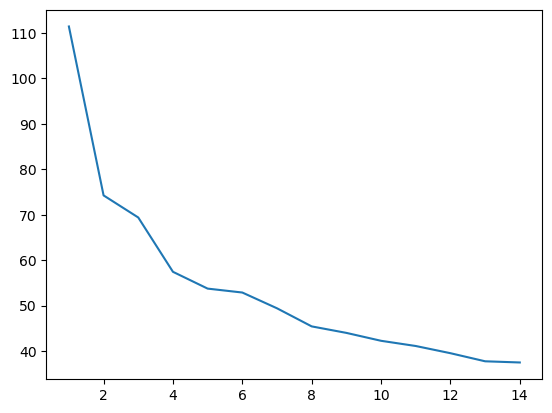

In [40]:
# construct k list
klist = [k for k in range(1,15)]

# loop k means
goodness = looping_kmeans(corporate2Dnew2, klist)
print(goodness)
plt.plot(klist, goodness)

According to the graph above, 2 and 4 seem to be pretty good choices for the number of clusters. I would prefer 4 as the correct number of clusters since the sum of squared distance continue to decline and the slope is relatively steep compared to the trend after 4 clusters. This also aligns with the usual categorization of the four sectors within our economy.

## Summary

In general, the self-implementation and sklearn implementation of k-means both give the same clustering result of 2 and 4 clusters. In terms of time and memory usage, our self-implementation of k-means is faster when it comes to smaller cluster numbers and the time usage increases drastically as the number of cluster increases. The sklearn k-means implementation has a steady growth even if the number of clusters increases by 10-fold. Both implementations take up similar amounts of peak memory usage. Using the elbowology comparison, we find that 4 sectors are the optimal clustering of the companies within the data set.

Given the nature of this data set, the financial indicators might not be the best factors for sector clustering and there are some outliers that are excluded from this data set. Future analysis can perform k-means on data sets with more relative information like bond performance to create better clusters.